# Project SHIELD - Feature Extraction Reference

This notebook demonstrates the physics-informed feature pipeline for autonomous sensor modality recognition. We extract time-domain, frequency-domain, and stability features from raw sensor signals to classify sensor types based on their characteristic noise profiles.

## 1. Setup and Data Loading

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import sys
import warnings
warnings.filterwarnings('ignore')

sys.path.insert(0, os.path.abspath('../src'))

from SensorDataLoader import SensorDataLoader
from physics_based_classification.feature_extractor import FeatureExtractor
from physics_based_classification.freq_domain_analyses import get_psd_welch, get_spectral_slope
from physics_based_classification.time_domain_analyses import get_statistical_moments
from physics_based_classification.allan_dev import get_allan_deviation

os.makedirs('figures', exist_ok=True)
os.makedirs('../src/physics_based_classification/models', exist_ok=True)

FS = 100.0
loader = SensorDataLoader(seed=42)
extractor = FeatureExtractor(fs=FS)

print(f"Sampling frequency: {FS} Hz")
print("Output directories: figures/, ../src/physics_based_classification/models/")

### Generate Synthetic Noise Types

Different sensor modalities exhibit different noise colors:
- **White noise** (flat PSD): Accelerometers
- **Pink noise** (1/f PSD): Gyroscopes, magnetometers
- **Brown noise** (1/f^2 PSD): Pressure, temperature sensors

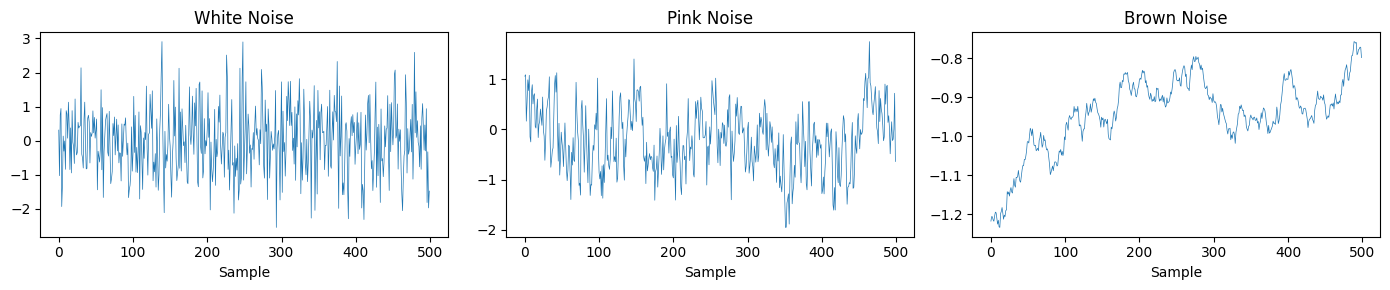

In [2]:
N_SAMPLES = 10000

white_signal = loader.generate_synthetic_data(N_SAMPLES, noise_type='white').flatten()
pink_signal = loader.generate_synthetic_data(N_SAMPLES, noise_type='pink').flatten()
brown_signal = loader.generate_synthetic_data(N_SAMPLES, noise_type='brown').flatten()

fig, axes = plt.subplots(1, 3, figsize=(14, 3))
for ax, sig, name in zip(axes, [white_signal, pink_signal, brown_signal], ['White', 'Pink', 'Brown']):
    ax.plot(sig[:500], linewidth=0.5)
    ax.set_title(f'{name} Noise')
    ax.set_xlabel('Sample')
plt.tight_layout()
plt.show()

### Load PAMAP2 Real Sensor Data

The PAMAP2 dataset contains IMU data (accelerometer, gyroscope, magnetometer) and temperature from wearable sensors.

In [ ]:
pamap_files = glob.glob('../datasets/PAMAP2_Dataset/Protocol/*.dat')
print(f"Found {len(pamap_files)} PAMAP2 subject files")

sensors = loader.load_pamap2(pamap_files[0])
sensors = loader.get_stationary_segments(sensors, activities=[2, 3])

print(f"\nAvailable sensors: {[k for k in sensors.keys() if 'hand' in k]}")
print(f"Samples after filtering: {len(sensors['timestamp'])}")

## 2. Time-Domain Feature Extraction

Statistical moments characterize the signal amplitude distribution:
- **Mean, variance, RMS**: Central tendency and spread
- **Skewness, kurtosis**: Distribution shape
- **ZCR (zero-crossing rate)**: Signal oscillation frequency

In [4]:
time_features_white = get_statistical_moments(white_signal)
time_features_pink = get_statistical_moments(pink_signal)
time_features_brown = get_statistical_moments(brown_signal)

time_df = pd.DataFrame({
    'White': time_features_white,
    'Pink': time_features_pink,
    'Brown': time_features_brown
}).T

print("Time-Domain Features by Noise Type:")
time_df.round(4)

Time-Domain Features by Noise Type:


,mean,variance,rms,skewness,kurtosis,zcr,quantile_25,quantile_50,quantile_75
White,-0.0,1.0,1.0,-0.0034,0.0533,0.4973,-0.6629,-0.0029,0.6561
Pink,-0.0,1.0,1.0,0.0389,-0.2265,0.1678,-0.6970,-0.0240,0.6844
Brown,0.0,1.0,1.0,-0.0124,-1.4647,0.0039,-1.0660,0.0237,0.9084


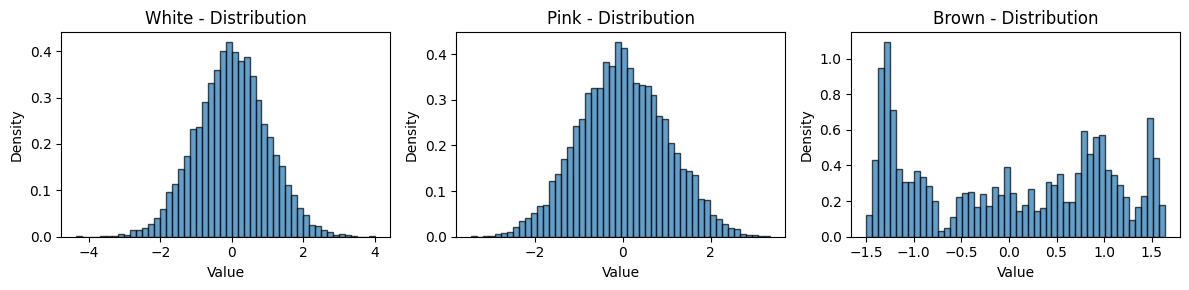

In [5]:
fig, axes = plt.subplots(1, 3, figsize=(12, 3))
for ax, sig, name in zip(axes, [white_signal, pink_signal, brown_signal], ['White', 'Pink', 'Brown']):
    ax.hist(sig, bins=50, density=True, alpha=0.7, edgecolor='black')
    ax.set_title(f'{name} - Distribution')
    ax.set_xlabel('Value')
    ax.set_ylabel('Density')
plt.tight_layout()
plt.show()

## 3. Frequency-Domain Feature Extraction

Power Spectral Density (PSD) reveals the noise color:
- **PSD slope**: The log-log slope discriminates noise types
  - White: slope ~ 0
  - Pink: slope ~ -1
  - Brown: slope ~ -2
- **Spectral flatness**: Higher for white noise (uniform energy)
- **Spectral entropy**: Complexity measure of the spectrum

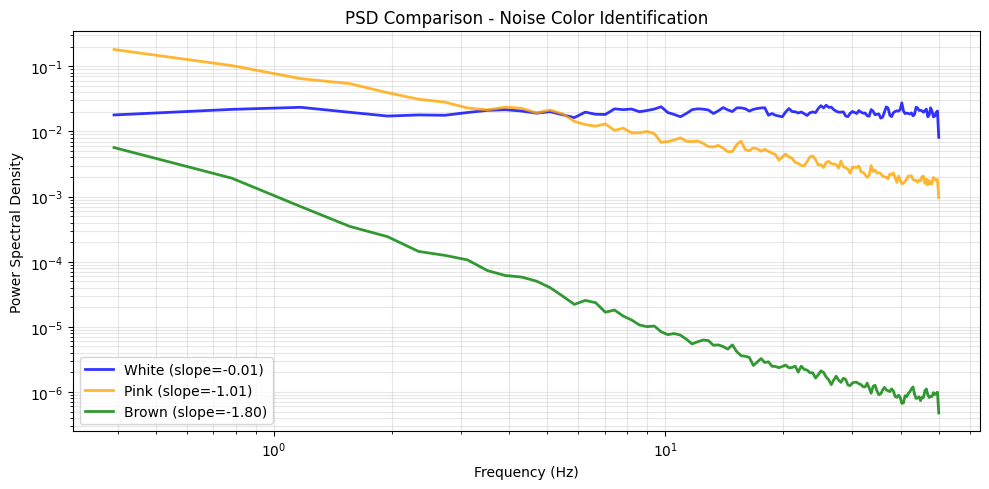

Saved: figures/psd_noise_colors.png


In [6]:
fig, ax = plt.subplots(figsize=(10, 5))

for sig, name, color in [(white_signal, 'White', 'blue'), 
                          (pink_signal, 'Pink', 'orange'),
                          (brown_signal, 'Brown', 'green')]:
    freqs, power = get_psd_welch(sig, fs=FS)
    slope = get_spectral_slope(freqs, power)
    mask = freqs > 0
    ax.loglog(freqs[mask], power[mask], label=f'{name} (slope={slope:.2f})', 
              color=color, alpha=0.8, linewidth=2)

ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Power Spectral Density')
ax.set_title('PSD Comparison - Noise Color Identification')
ax.legend()
ax.grid(True, which='both', alpha=0.3)
plt.tight_layout()
plt.savefig('figures/psd_noise_colors.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: figures/psd_noise_colors.png")

In [ ]:
from physics_based_classification.freq_domain_analyses import extract_freq_features

freq_df = pd.DataFrame({
    'White': extract_freq_features(white_signal, FS),
    'Pink': extract_freq_features(pink_signal, FS),
    'Brown': extract_freq_features(brown_signal, FS)
}).T

print("Frequency-Domain Features by Noise Type:")
freq_df.round(4)

## 4. Stability Features (Allan Deviation)

Allan Deviation (ADEV) characterizes sensor stability over different integration times (tau):
- **ADEV slope ~ -0.5**: White noise (Angle Random Walk)
- **ADEV slope ~ 0**: Flicker noise (Bias Instability)
- **ADEV slope ~ +0.5**: Random walk (Rate Random Walk)

This is the standard metric for inertial sensor characterization.

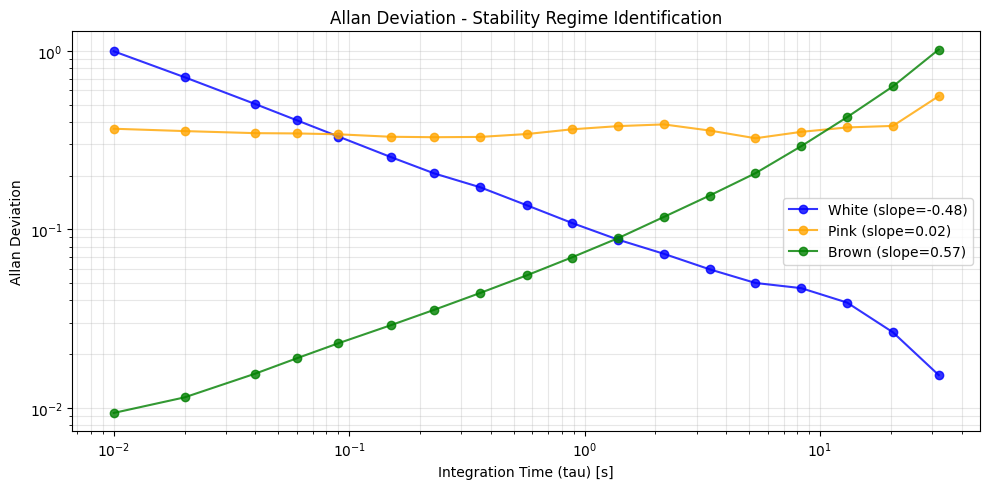

Saved: figures/allan_deviation.png


In [8]:
import allantools

fig, ax = plt.subplots(figsize=(10, 5))

for sig, name, color in [(white_signal, 'White', 'blue'),
                          (pink_signal, 'Pink', 'orange'),
                          (brown_signal, 'Brown', 'green')]:
    max_tau = len(sig) / FS / 2.0
    taus = np.logspace(np.log10(1.0/FS), np.log10(max_tau), num=20)
    taus_out, ad, ade, ns = allantools.oadev(sig, rate=FS, data_type='freq', taus=taus)
    
    log_t = np.log10(taus_out)
    log_ad = np.log10(ad)
    slope, _ = np.polyfit(log_t, log_ad, 1)
    
    ax.loglog(taus_out, ad, 'o-', label=f'{name} (slope={slope:.2f})', color=color, alpha=0.8)

ax.set_xlabel('Integration Time (tau) [s]')
ax.set_ylabel('Allan Deviation')
ax.set_title('Allan Deviation - Stability Regime Identification')
ax.legend()
ax.grid(True, which='both', alpha=0.3)
plt.tight_layout()
plt.savefig('figures/allan_deviation.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: figures/allan_deviation.png")

In [9]:
adev_df = pd.DataFrame({
    'White': get_allan_deviation(white_signal, FS),
    'Pink': get_allan_deviation(pink_signal, FS),
    'Brown': get_allan_deviation(brown_signal, FS)
}).T

print("Allan Deviation Features by Noise Type:")
adev_df.round(4)

Allan Deviation Features by Noise Type:


,adev_0.01s,adev_0.03s,adev_0.07s,adev_0.17s,adev_0.44s,adev_1.13s,adev_2.92s,adev_7.53s,adev_19.41s,adev_slope
White,0.9951,0.5836,0.3754,0.2389,0.1569,0.0971,0.0640,0.0476,0.0283,-0.4659
Pink,0.3662,0.3489,0.3438,0.3287,0.3319,0.3722,0.3710,0.3389,0.3724,0.0045
Brown,0.0093,0.0136,0.0204,0.0307,0.0485,0.0795,0.1409,0.2690,0.6010,0.5414


## 5. Build Full Feature Dataset from PAMAP2

Extract features from all sensor modalities in the PAMAP2 dataset.

In [ ]:
def build_modality_dataset(data_dir, max_files=None):
    files = glob.glob(f"{data_dir}/*.dat")
    if max_files:
        files = files[:max_files]
    
    modality_map = {
        'accel_16g': 'accelerometer',
        'accel_6g': 'accelerometer', 
        'gyro': 'gyroscope',
        'mag': 'magnetometer',
        'temp': 'temperature'
    }
    
    all_features = []
    
    for filepath in files:
        print(f"Processing {filepath.split('/')[-1]}...")
        sensors = loader.load_pamap2(filepath)
        sensors = loader.get_stationary_segments(sensors, activities=[2, 3])
        
        for location in ['hand', 'chest', 'ankle']:
            for sensor_type, modality in modality_map.items():
                key = f'{location}_{sensor_type}'
                data = sensors[key]
                
                if data.ndim == 1:
                    data = data[~np.isnan(data)]
                    if len(data) < 1000:
                        continue
                    df = extractor.process_signal(data, 2.0, 1.0)
                    df['modality'] = modality
                    all_features.append(df)
                else:
                    for axis in range(data.shape[1]):
                        sig = data[:, axis]
                        sig = sig[~np.isnan(sig)]
                        if len(sig) < 1000:
                            continue
                        df = extractor.process_signal(sig, 2.0, 1.0)
                        df['modality'] = modality
                        all_features.append(df)
    
    return pd.concat(all_features, ignore_index=True)

feature_df = build_modality_dataset('../datasets/PAMAP2_Dataset/Protocol', max_files=3)
print(f"\nDataset shape: {feature_df.shape}")
print(f"Modalities: {feature_df['modality'].unique()}")
print(f"\nSamples per modality:")
print(feature_df['modality'].value_counts())

## 6. Feature Separability Plots

Visualize how well features separate different sensor modalities.

### 6.1 Pairwise Scatter Plots

Show relationships between the most discriminative features.

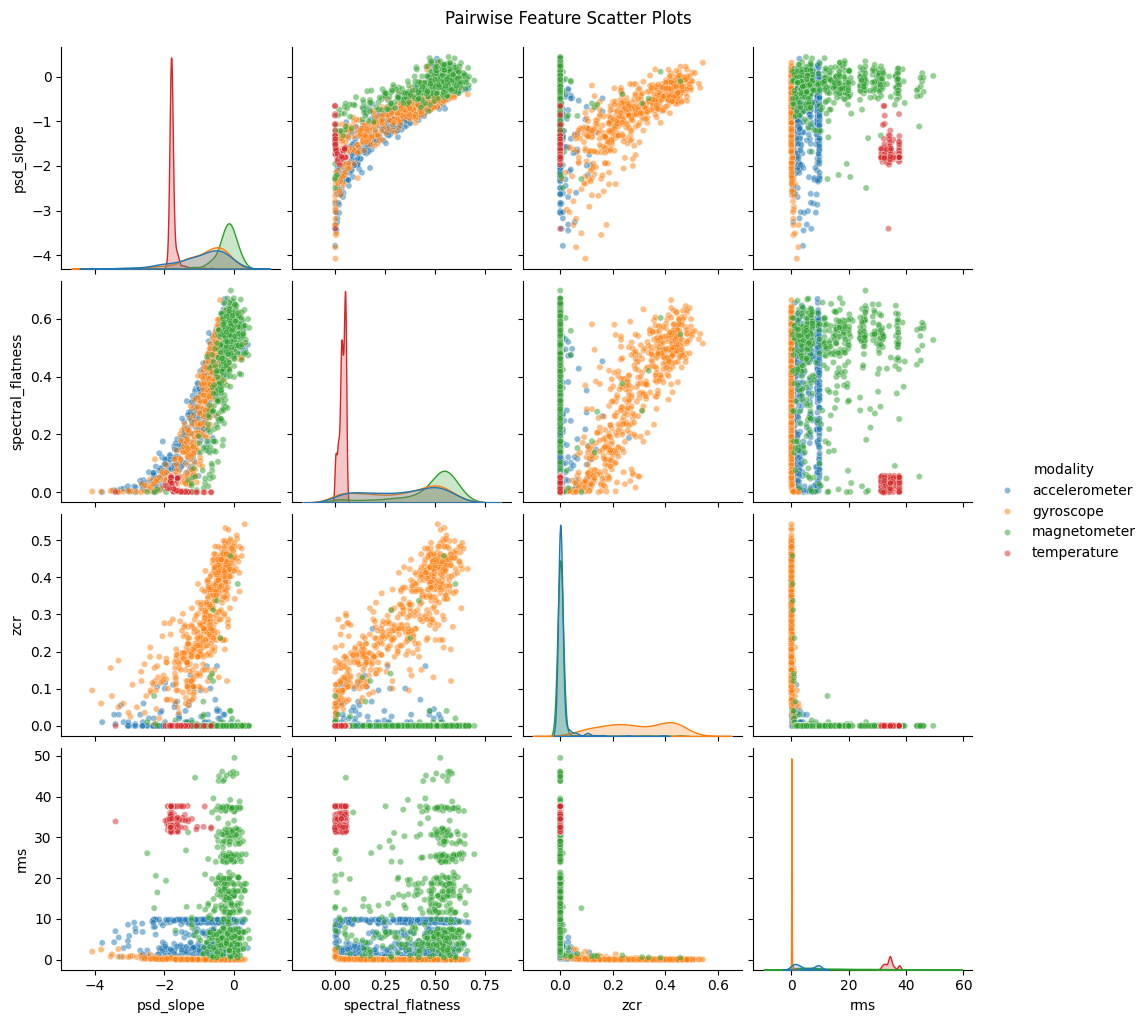

Saved: figures/pairwise_scatter.png


In [11]:
top_features = ['psd_slope', 'spectral_flatness', 'zcr', 'rms']
existing_features = [f for f in top_features if f in feature_df.columns]

plot_df = feature_df[existing_features + ['modality']].dropna()
plot_df_sampled = plot_df.groupby('modality').apply(lambda x: x.sample(min(500, len(x)), random_state=42)).reset_index(drop=True)

g = sns.pairplot(plot_df_sampled, vars=existing_features, hue='modality', 
                 palette='tab10', plot_kws={'alpha': 0.5, 's': 20})
g.fig.suptitle('Pairwise Feature Scatter Plots', y=1.02)
plt.savefig('figures/pairwise_scatter.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: figures/pairwise_scatter.png")

### 6.2 PCA Visualization

Project high-dimensional feature space to 2D using Principal Component Analysis.

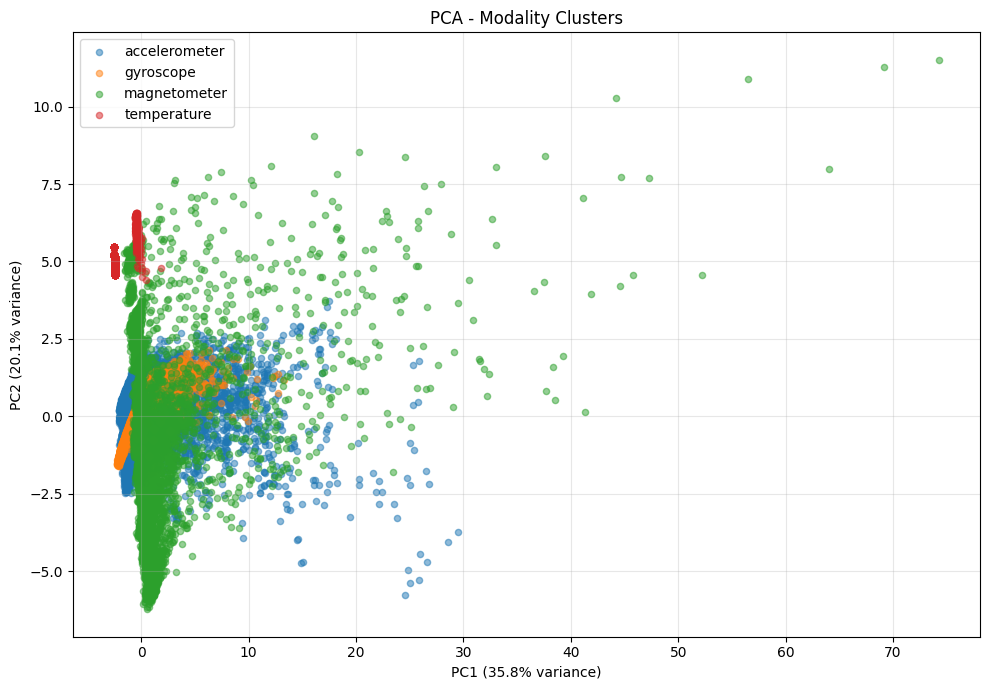

Total variance explained by 2 components: 56.0%
Saved: figures/pca_clusters.png


In [12]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

meta_cols = ['window_start_sample', 'window_start_sec', 'modality']
feature_cols = [c for c in feature_df.columns if c not in meta_cols]

X = feature_df[feature_cols].fillna(0).values
y = feature_df['modality'].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

fig, ax = plt.subplots(figsize=(10, 7))
for modality in np.unique(y):
    mask = y == modality
    ax.scatter(X_pca[mask, 0], X_pca[mask, 1], label=modality, alpha=0.5, s=20)

ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
ax.set_title('PCA - Modality Clusters')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('figures/pca_clusters.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Total variance explained by 2 components: {sum(pca.explained_variance_ratio_):.1%}")
print("Saved: figures/pca_clusters.png")

### 6.3 UMAP Visualization

Non-linear dimensionality reduction that preserves local structure better than PCA.

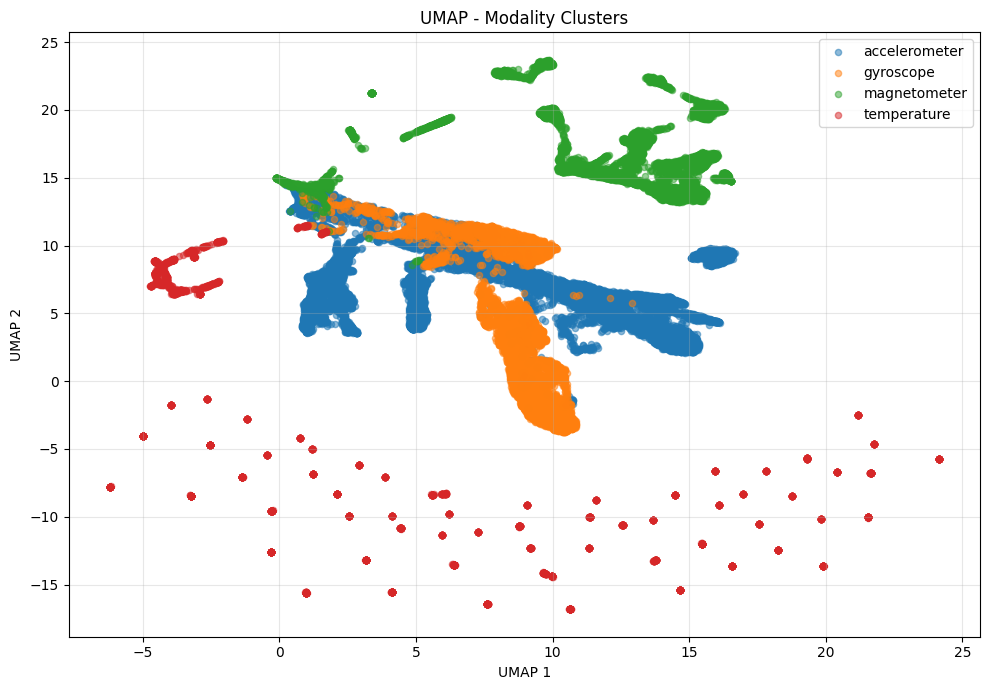

Saved: figures/umap_clusters.png


In [13]:
import umap

reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42, n_jobs=1)
X_umap = reducer.fit_transform(X_scaled)

fig, ax = plt.subplots(figsize=(10, 7))
for modality in np.unique(y):
    mask = y == modality
    ax.scatter(X_umap[mask, 0], X_umap[mask, 1], label=modality, alpha=0.5, s=20)

ax.set_xlabel('UMAP 1')
ax.set_ylabel('UMAP 2')
ax.set_title('UMAP - Modality Clusters')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('figures/umap_clusters.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: figures/umap_clusters.png")

## 7. Classification Demo

Train a Random Forest classifier to predict sensor modality from extracted features.

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import joblib

le = LabelEncoder()
y_encoded = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

clf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
clf.fit(X_train, y_train)

cv_scores = cross_val_score(clf, X_train, y_train, cv=5)
print(f"Cross-validation accuracy: {cv_scores.mean():.3f} (+/- {cv_scores.std()*2:.3f})")

y_pred = clf.predict(X_test)
print(f"\nTest accuracy: {(y_pred == y_test).mean():.3f}")
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

Cross-validation accuracy: 0.993 (+/- 0.002)

Test accuracy: 0.993

Classification Report:
               precision    recall  f1-score   support

accelerometer       0.99      0.99      0.99      3088
    gyroscope       0.99      0.99      0.99      1544
 magnetometer       1.00      1.00      1.00      1544
  temperature       1.00      1.00      1.00       514

     accuracy                           0.99      6690
    macro avg       0.99      0.99      0.99      6690
 weighted avg       0.99      0.99      0.99      6690



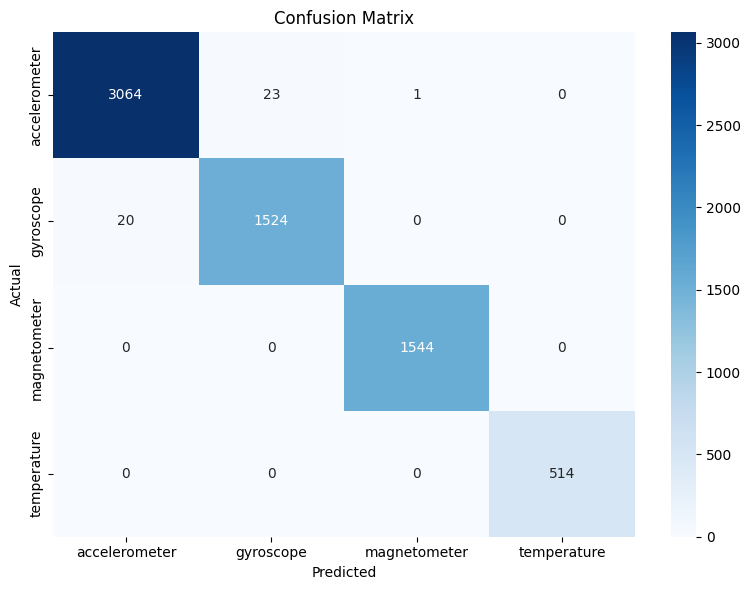

Saved: figures/confusion_matrix.png


In [15]:
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, yticklabels=le.classes_, ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix')
plt.tight_layout()
plt.savefig('figures/confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: figures/confusion_matrix.png")

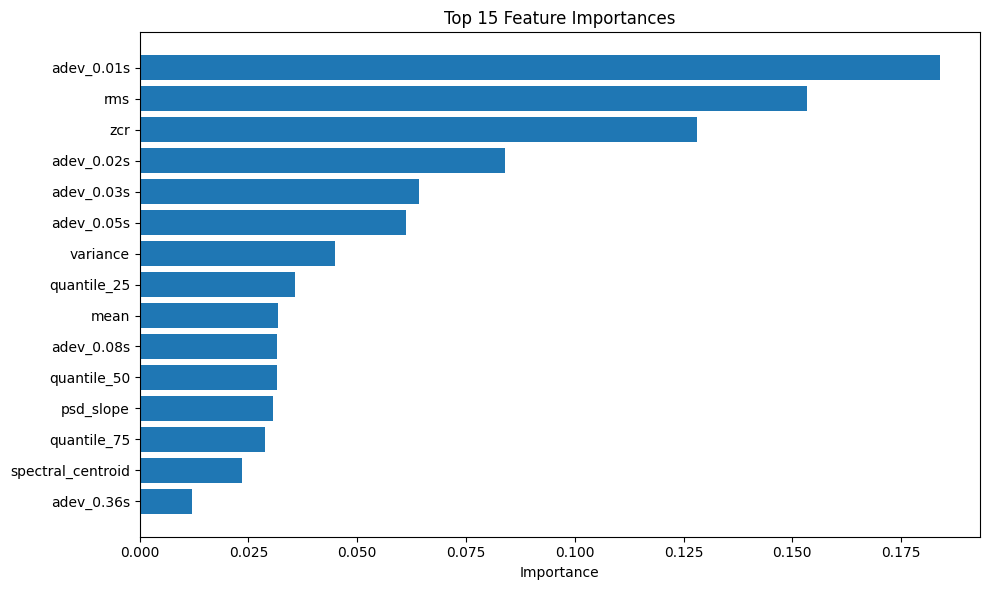

Saved: figures/feature_importance.png


In [16]:
importances = pd.DataFrame({
    'feature': feature_cols,
    'importance': clf.feature_importances_
}).sort_values('importance', ascending=True).tail(15)

fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(importances['feature'], importances['importance'])
ax.set_xlabel('Importance')
ax.set_title('Top 15 Feature Importances')
plt.tight_layout()
plt.savefig('figures/feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: figures/feature_importance.png")

## 8. Save Model Artifacts

Save trained model, scaler, and label encoder for the prediction system.

In [ ]:
joblib.dump(clf, '../src/physics_based_classification/models/rf_classifier.joblib')
joblib.dump(scaler, '../src/physics_based_classification/models/scaler.joblib')
joblib.dump(le, '../src/physics_based_classification/models/label_encoder.joblib')
joblib.dump(feature_cols, '../src/physics_based_classification/models/feature_columns.joblib')

print("Saved model artifacts:")
print("  - ../src/physics_based_classification/models/rf_classifier.joblib")
print("  - ../src/physics_based_classification/models/scaler.joblib") 
print("  - ../src/physics_based_classification/models/label_encoder.joblib")
print("  - ../src/physics_based_classification/models/feature_columns.joblib")

## 9. Prediction Demo

Demonstrate the prediction workflow: raw signal -> features -> modality prediction.

In [18]:
test_signals = {
    'white_noise': loader.generate_synthetic_data(5000, noise_type='white').flatten(),
    'pink_noise': loader.generate_synthetic_data(5000, noise_type='pink').flatten(),
    'brown_noise': loader.generate_synthetic_data(5000, noise_type='brown').flatten()
}

for name, signal in test_signals.items():
    df = extractor.process_signal(signal, 2.0, 1.0)
    X_new = df[feature_cols].fillna(0).values
    X_new_scaled = scaler.transform(X_new)
    
    preds = clf.predict(X_new_scaled)
    probs = clf.predict_proba(X_new_scaled)
    
    pred_labels = le.inverse_transform(preds)
    most_common = pd.Series(pred_labels).mode()[0]
    confidence = (pred_labels == most_common).mean()
    
    print(f"{name}:")
    print(f"  Predicted modality: {most_common}")
    print(f"  Confidence: {confidence:.1%}")
    print(f"  Distribution: {pd.Series(pred_labels).value_counts().to_dict()}")
    print()

white_noise:
  Predicted modality: accelerometer
  Confidence: 100.0%
  Distribution: {'accelerometer': 49}

pink_noise:
  Predicted modality: accelerometer
  Confidence: 100.0%
  Distribution: {'accelerometer': 49}

brown_noise:
  Predicted modality: accelerometer
  Confidence: 89.8%
  Distribution: {'accelerometer': 44, 'gyroscope': 5}



In [ ]:
from physics_based_classification.predictor import SensorPredictor

predictor = SensorPredictor()

test_signal = loader.generate_synthetic_data(5000, noise_type='white').flatten()
result = predictor.predict(test_signal, fs=100.0)

print("Prediction using SensorPredictor:")
print(f"  Modality: {result['modality']}")
print(f"  Confidence: {result['confidence']:.1%}")
print(f"  Probabilities: {result['probabilities']}")

## Summary

This notebook demonstrated:

1. **Time-domain features**: Statistical moments (mean, variance, RMS, skewness, kurtosis) and zero-crossing rate
2. **Frequency-domain features**: PSD slope (key noise color discriminator), spectral entropy, flatness, and centroid
3. **Stability features**: Allan deviation characterizes sensor stability regimes
4. **Feature separability**: Pairwise scatter plots, PCA, and UMAP visualizations show clear modality clustering
5. **Classification**: Random Forest achieves high accuracy on sensor modality prediction

The saved model can be used via `predictor.py` for real-time sensor modality detection.